<a href="https://colab.research.google.com/github/S-loaiza-UAO/Machine-learning-UAO/blob/main/Proyecto_final_aprendizaje_automatico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: aprendizaje Automático

**Objetivo:** Implementación de un modelo de aprendizaje supervisado para la predicción y clasificación en dos estados de una condición operativa que se presenta en el proceso de vapor de un ingenio azucarero colombiano y que afecta la eficiencia energética.

**Data Set:** El conjunto de datos es obtenido a través de los diferentes sensores y medidores en campo, los cuales son almacenados en el sistema de control. Desde allí se obtienen algunas variables representativas con las cuales se puede entrenar el modelo. Cada fila corresponde a una condición aleatoria en una fecha aleatoria, la cual ha sido analizada para determinar si aplica o no. De alli se compone un archivo de 150 filas o registros x 9 columnas o atributos "[150,9]".

**Variables:**

1. Rata de molienda (m3/h): indica la fase inicio del proceso de molienda donde se determinan los flujos iniciales de operación.
2. Flujo de jugo claro al 1er efecto de evaporación (m3/h): Postierior al proceso de purificacion del jugo de molienda y con la recepcion de retornos se inicia bombeo a evaporación.
3. Temperatura de jugo claro al 1er efecto después del calentamiento (°C): Parte de la eficiencia del proceso de evaporación esta determinada por la temperatura del jugo claro, ya que menores temperaturas indicaran aumento en los flujos de vapor para obtener temperaturas a presión de saturación.
4. Presión de vapor en calandria (psig): Esta variable indica la presion manometrica de vapor de escape saturado que ingresa al intercambiador.
5. Apertura de válvula de control de vapor (%).
6. Flujo de vapor de escape a evaporación (Klb/h): Este valor es un estimativo del flujo que ingresa a fabrica de azucar y se por la diferencia del vapor total generado - el vapor destinado a la condensación.
7. Flujo total de vapor vivo generado (Klb/h)
8. Flujo de vapor a condensación (Klb/h).
9. Exceso de vapor o la variable objetivo y esta indicada en valor BINARIO donde: 0 == NO y 1 == SI.






# Importación de Librerías


In [180]:
# Importación de librerías
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from matplotlib.patheffects import withStroke
from scipy import stats
import numpy as np
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, precision_score, recall_score

# Etapa 1: Importe de Data Set y tratamiento inicial de la información.

In [181]:
!git clone https://github.com/S-loaiza-UAO/Machine-learning-UAO
%cd Machine-learning-UAO

Cloning into 'Machine-learning-UAO'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 22), reused 22 (delta 8), pack-reused 0
Receiving objects: 100% (58/58), 4.09 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/Machine-learning-UAO/Machine-learning-UAO/Machine-learning-UAO/Machine-learning-UAO/Machine-learning-UAO/Machine-learning-UAO


In [182]:
df = pd.read_csv("DATA_SET_EVMC_V2.csv",sep=";", index_col=False, encoding='latin1')                                   # Lectura del archivo CSV cargado anteriormente
df = df.replace(',', '.', regex=True)                                                                         # Para evitar problemas en la lectura de los numeros decimales que vienen separados con ",", se hace un reemplazo a puntos"."
df.columns = ["RATA DE MOLIENDA (m3/h)", "FLUJO DE JUGO CLARO (m3/h)", "TEMPERATURA DE JUGO CLARO (°C)",
             "PRESION PSIG CALANDRIA 1","% APERTURA VALVULA VAPOR CALANDRIA 1","FLUJO VAPOR EVAPORACION",
              "FLUJO VAPOR VIVO TOTAL","FLUJO VAPOR CONDENSACION","EXCESO VAPOR"]
df.head()

,RATA DE MOLIENDA (m3/h),FLUJO DE JUGO CLARO (m3/h),TEMPERATURA DE JUGO CLARO (°C),PRESION PSIG CALANDRIA 1,% APERTURA VALVULA VAPOR CALANDRIA 1,FLUJO VAPOR EVAPORACION,FLUJO VAPOR VIVO TOTAL,FLUJO VAPOR CONDENSACION,EXCESO VAPOR
0,220,218,108.0,16.54,94.47,231.74,320.0,88,0.
1,228,240,106.0,17.17,67.76,278.41,325.0,47,1.
2,184,267,107.0,18.5,51.85,217.76,310.0,92,1.
3,202,227,105.0,18.51,67.29,217.76,310.0,92,0.
4,193,239,109.0,18.52,67.4,235.52,294.0,58,1.


In [183]:
print("Tamaño del conjunto de datos:",df.shape)# Imprimir parte de los datos den data_frame

Tamaño del conjunto de datos: (150, 9)


In [184]:
atributos= df.columns
print(atributos)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
       '% APERTURA VALVULA VAPOR CALANDRIA 1', 'FLUJO VAPOR EVAPORACION',
       'FLUJO VAPOR VIVO TOTAL', 'FLUJO VAPOR CONDENSACION', 'EXCESO VAPOR'],
      dtype='object')


In [185]:
# Información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               148 non-null    object 
 1   FLUJO DE JUGO CLARO (m3/h)            149 non-null    object 
 2   TEMPERATURA DE JUGO CLARO (°C)        146 non-null    float64
 3   PRESION PSIG CALANDRIA 1              149 non-null    object 
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  149 non-null    object 
 5   FLUJO VAPOR EVAPORACION               148 non-null    object 
 6   FLUJO VAPOR VIVO TOTAL                148 non-null    float64
 7   FLUJO VAPOR CONDENSACION              149 non-null    object 
 8   EXCESO VAPOR                          149 non-null    object 
dtypes: float64(2), object(7)
memory usage: 10.7+ KB
None


Tal y como se observa anteriormente algunos de los atributos que deberian ser numéricos, aparecen como categóricos. Por lo tanto se realizara una conversion de los atributos a float64.
Esto puede ocurrir por la presencia de datos mal escritos o tal vez por la forma como estan escritos algunos de los números decimales con "punto" y no con "coma".

Tambien se observa que hay variables que presentan diferencia en los valores de los registros, se realizara un barrido de los registros para identificar que datos se presentan.

In [186]:
variable_categorica= df.select_dtypes(include=['object']).columns[0:]
print(variable_categorica)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'PRESION PSIG CALANDRIA 1', '% APERTURA VALVULA VAPOR CALANDRIA 1',
       'FLUJO VAPOR EVAPORACION', 'FLUJO VAPOR CONDENSACION', 'EXCESO VAPOR'],
      dtype='object')


En el siguiente aparte seran revisados los atributos que presentan registros faltantes o en blanco.

In [187]:
# Contar valores nulos por columna
df.isnull().sum()

RATA DE MOLIENDA (m3/h)                 2
FLUJO DE JUGO CLARO (m3/h)              1
TEMPERATURA DE JUGO CLARO (°C)          4
PRESION PSIG CALANDRIA 1                1
% APERTURA VALVULA VAPOR CALANDRIA 1    1
FLUJO VAPOR EVAPORACION                 2
FLUJO VAPOR VIVO TOTAL                  2
FLUJO VAPOR CONDENSACION                1
EXCESO VAPOR                            1
dtype: int64

A continuacion seran evaluados los registros que no son nulos pero que pueden estar como valores no numericos e identificar que tipo de registro contiene y lograr la conversion correctamente.

In [188]:
def identificar_no_numericos(df1, atributos):
  """
  Esta función identifica los datos no numéricos en una serie de atributos de un DataFrame.

  Parámetros:
    df: El DataFrame que contiene los datos.
    atributos: Una lista con los nombres de los atributos que se desean analizar.

  Retorno:
    Un diccionario con los nombres de los atributos como claves y las listas de valores no numéricos como valores.
  """
  no_numericos = {}
  for atributo in atributos:
    no_numericos[atributo] = []
    for i, valor in enumerate(df[atributo]):
      try:
        # Convertimos el valor a un número flotante
        float(valor)
      except ValueError:
        # Si no se puede convertir, es un dato no numérico
        no_numericos[atributo].append(valor)
  return no_numericos

df1=df.copy()
#atributos= ['RATA DE MOLIENDA (m3/h)', 'TEMPERATURA DE JUGO CLARO (°C)','FLUJO VAPOR EVAPORACION', 'FLUJO VAPOR VIVO TOTAL', 'EXCESO VAPOR']
no_numericos = identificar_no_numericos(df, atributos)
print(no_numericos)

{'RATA DE MOLIENDA (m3/h)': ['199;284;108;16.62;99.64'], 'FLUJO DE JUGO CLARO (m3/h)': [], 'TEMPERATURA DE JUGO CLARO (°C)': [], 'PRESION PSIG CALANDRIA 1': [], '% APERTURA VALVULA VAPOR CALANDRIA 1': ['1..'], 'FLUJO VAPOR EVAPORACION': [], 'FLUJO VAPOR VIVO TOTAL': [], 'FLUJO VAPOR CONDENSACION': [], 'EXCESO VAPOR': ['si.', 'no.', '0..', 'SI.', 'no aplica.', '0..', '1..', 'no.', '0..', '0..', 'si.', 'SI ES', 'NO']}


De acuerdo con el resultado obtenido, la variable:
* Rata molienda: presenta 2 valores atipicos separados por "punto" y no por "coma".
* Temperatura de jugo claro tiene 4 registros en blanco
* Presión de calandria, apertura de valvula de control y flujo a condensacion tienen 1 registro en blanco cada uno.
* Flujo vapor evaporacion y flujo vapor vivo total contienen cada atributo 2 registros en blanco.
* El atributo EXCESO VAPOR presenta mas variaciones en los datos, 1 dato en blanco y otros registros tales como: ['si.', 'no.', '0..', 'SI.', 'no aplica.', '0..', '1..', 'no.', '0..', '0..', 'si.', 'SI ES', 'NO']

Se realizara un primer barrido eliminando los datos nulos de las variables. Asi podremos evaluar la cantidad de registros que finalmente obtendremos.

In [189]:
# Eliminar filas que contienen valores nulos
df = df[~df.isnull().any(axis=1)]

# Eliminar filas que contienen valores blancos
df = df[~df.eq('').any(axis=1)]

# Contar valores nulos por columna
df.isnull().sum()

RATA DE MOLIENDA (m3/h)                 0
FLUJO DE JUGO CLARO (m3/h)              0
TEMPERATURA DE JUGO CLARO (°C)          0
PRESION PSIG CALANDRIA 1                0
% APERTURA VALVULA VAPOR CALANDRIA 1    0
FLUJO VAPOR EVAPORACION                 0
FLUJO VAPOR VIVO TOTAL                  0
FLUJO VAPOR CONDENSACION                0
EXCESO VAPOR                            0
dtype: int64

Realizamos la conversion de los atributos dtype: object a float64 y revisamos nuevamente el conteo de registros disponibles.
En este caso exeptuaremos la variable EXCESO VAPOR, donde se evidencia un total de 139 registros de 149 inicialmente, fueron eliminados 10 registros nulos.

In [190]:
df['RATA DE MOLIENDA (m3/h)'] = df['RATA DE MOLIENDA (m3/h)'].astype('float64')
df['FLUJO DE JUGO CLARO (m3/h)'] = df['FLUJO DE JUGO CLARO (m3/h)'].astype('float64')
df['PRESION PSIG CALANDRIA 1'] = df['PRESION PSIG CALANDRIA 1'].astype('float64')
df['% APERTURA VALVULA VAPOR CALANDRIA 1'] = df['% APERTURA VALVULA VAPOR CALANDRIA 1'].astype('float64')
df['FLUJO VAPOR EVAPORACION'] = df['FLUJO VAPOR EVAPORACION'].astype('float64')
df['FLUJO VAPOR CONDENSACION'] = df['FLUJO VAPOR CONDENSACION'].astype('float64')

# Información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 148
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               139 non-null    float64
 1   FLUJO DE JUGO CLARO (m3/h)            139 non-null    float64
 2   TEMPERATURA DE JUGO CLARO (°C)        139 non-null    float64
 3   PRESION PSIG CALANDRIA 1              139 non-null    float64
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  139 non-null    float64
 5   FLUJO VAPOR EVAPORACION               139 non-null    float64
 6   FLUJO VAPOR VIVO TOTAL                139 non-null    float64
 7   FLUJO VAPOR CONDENSACION              139 non-null    float64
 8   EXCESO VAPOR                          139 non-null    object 
dtypes: float64(8), object(1)
memory usage: 10.9+ KB
None


Con el analisis de registros no numericos, podemos hacer un reemplazo de los datos para asi evitar perder mas registros en el data set.

In [191]:
# Reemplazar valores string por float
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('si.', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('SI.', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('1..', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('SI ES', 1)
# Reemplazar valores string por float
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('no.', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('0..', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('no aplica.', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('NO', 0)
# Reemplazar valores string por float usando expresiones regulares
#df['Columna'] = df['Columna'].str.replace('[a-z]', 1.0)


In [192]:
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].astype('float64')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 148
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               139 non-null    float64
 1   FLUJO DE JUGO CLARO (m3/h)            139 non-null    float64
 2   TEMPERATURA DE JUGO CLARO (°C)        139 non-null    float64
 3   PRESION PSIG CALANDRIA 1              139 non-null    float64
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  139 non-null    float64
 5   FLUJO VAPOR EVAPORACION               139 non-null    float64
 6   FLUJO VAPOR VIVO TOTAL                139 non-null    float64
 7   FLUJO VAPOR CONDENSACION              139 non-null    float64
 8   EXCESO VAPOR                          139 non-null    float64
dtypes: float64(9)
memory usage: 10.9 KB
None


In [193]:
# Estadísticas descriptivas
print(df.describe())

       RATA DE MOLIENDA (m3/h)  FLUJO DE JUGO CLARO (m3/h)  \
count               139.000000                  139.000000   
mean                206.625899                  249.625899   
std                  15.434891                   24.605370   
min                 180.000000                  181.000000   
25%                 193.000000                  233.000000   
50%                 207.000000                  249.000000   
75%                 220.500000                  269.500000   
max                 230.000000                  290.000000   

       TEMPERATURA DE JUGO CLARO (°C)  PRESION PSIG CALANDRIA 1  \
count                      139.000000                139.000000   
mean                       107.776978                 18.303237   
std                          3.778358                  1.199748   
min                         90.000000                 13.910000   
25%                        106.000000                 17.635000   
50%                        108.000000  

# Resumen Etapa 1

* Clonar repositorio desde GitHub y cargar archivo .csv
* Revisión inicial del DataSet: tamaño, tipo de registros, atributos.
* Primera revision de valor nulos o faltantes.
* Revisión de valores no numericos - no nulos para reemplazar.
* Segunda revisión de tamaño de registros y transformacion de todos los atributos a dtype: float64
* Finalmente se obtienen variables estadisticas mas descriptivas del dataset con un tamaño final de 139 registros en 9 atributos.


In [194]:
df1=df.copy()

# Etapa 2: Preprocesamiento de datos y EDA
* Gráfico de dispersion de las variables.
* Correlación de variables por metodo Pearson, Spearman y Kendall
* Distribución de datos mediante histogramas y teniendo como base la variable objetivo.
* Graficacion de informacion mediante cajas y bigotes general y teniendo como base la variable objetivo.



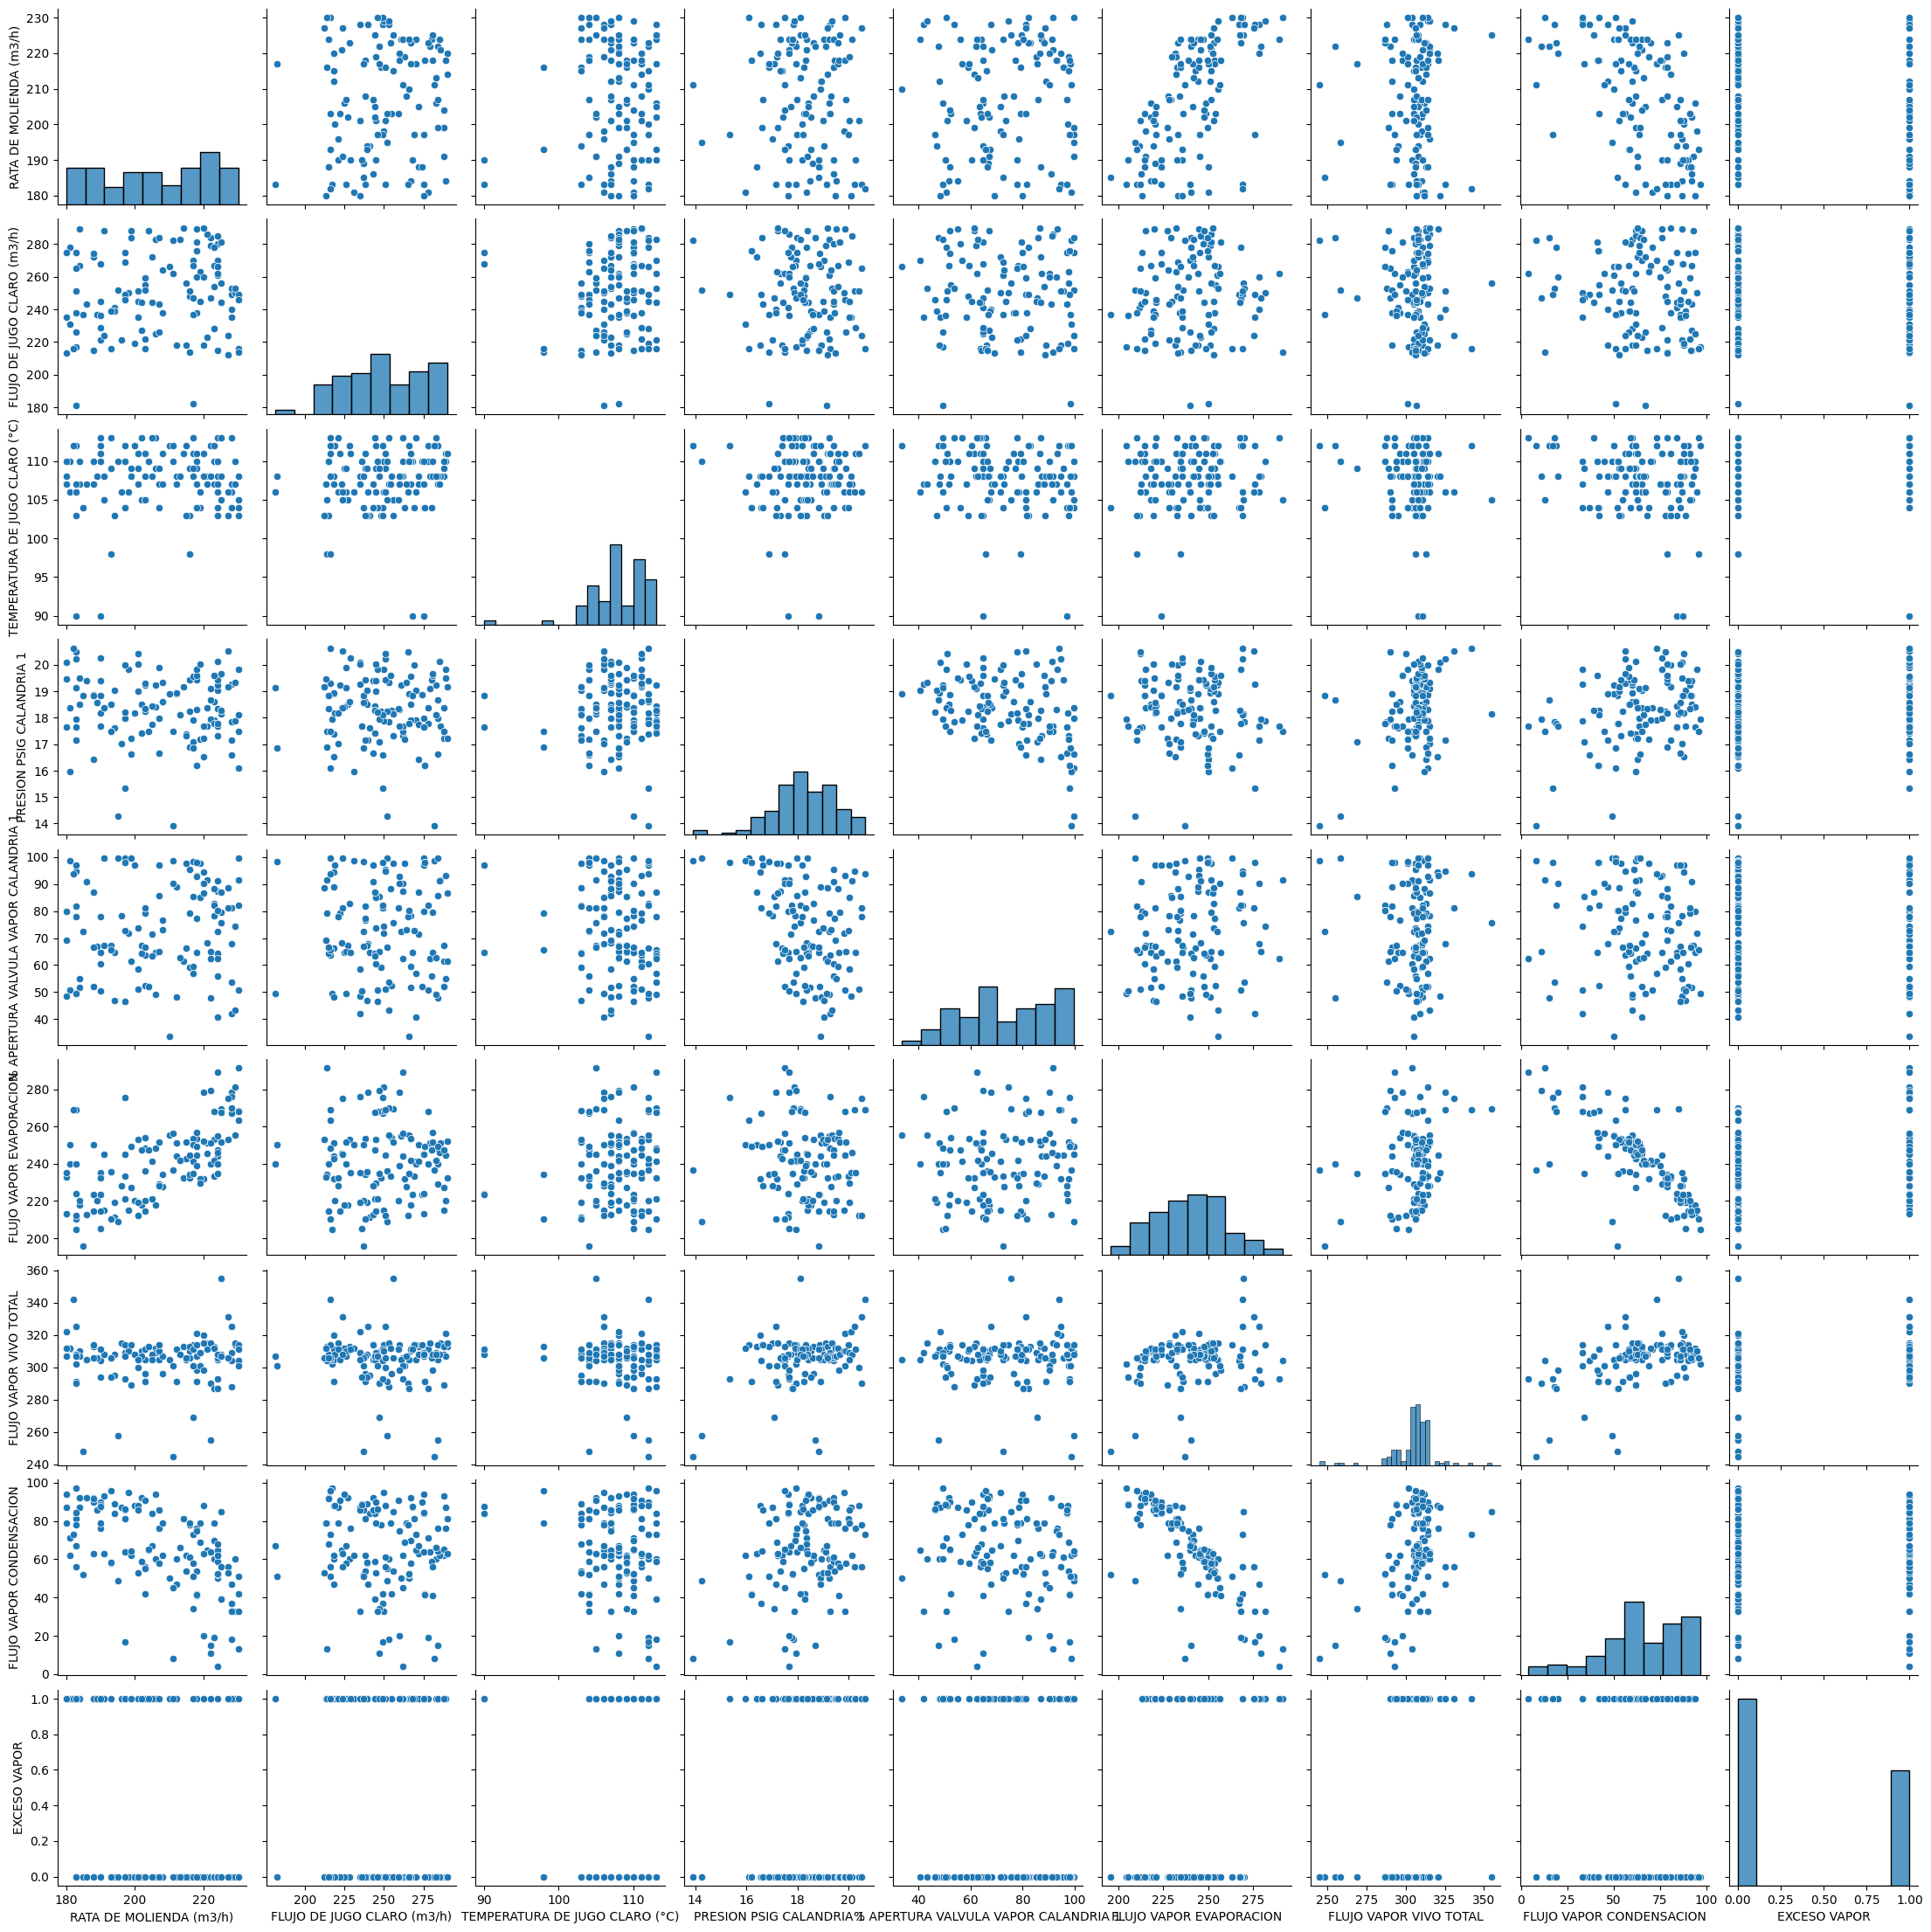

In [195]:
sns.pairplot(df1)

Text(0, 0.5, 'FLUJO VAPOR CONDENSACION')

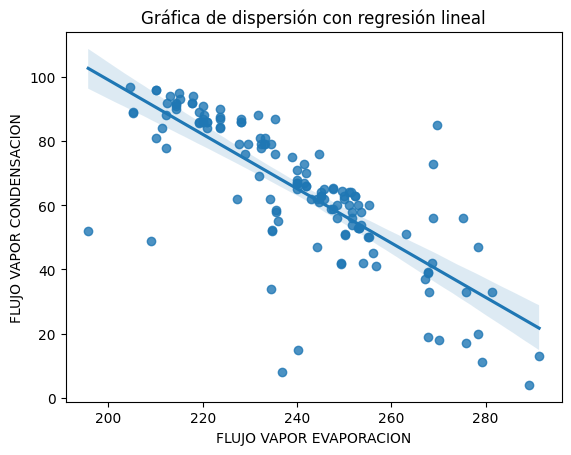

In [196]:
sns.regplot(x='FLUJO VAPOR EVAPORACION', y='FLUJO VAPOR CONDENSACION', data=df1)
plt.title('Gráfica de dispersión con regresión lineal')
plt.xlabel('FLUJO VAPOR EVAPORACION')
plt.ylabel('FLUJO VAPOR CONDENSACION')

Text(0, 0.5, 'FLUJO VAPOR EVAPORACIO')

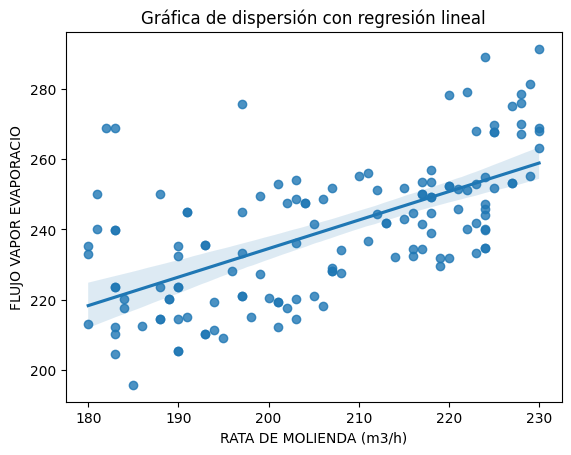

In [197]:
sns.regplot(x='RATA DE MOLIENDA (m3/h)', y='FLUJO VAPOR EVAPORACION', data=df1)
plt.title('Gráfica de dispersión con regresión lineal')
plt.xlabel('RATA DE MOLIENDA (m3/h)')
plt.ylabel('FLUJO VAPOR EVAPORACIO')

En esta primer etapa logramos evidenciar que:
* A mayor rata de molienda, el flujo de vapor hacia la evaporación aumenta proporcionalmente.
* Esto a su vez conlleva a que el flujo de vapor hacia la condensación de las turbinas disminuya. Por lo tanto es inversamente proporcional a la rata de molienda.

A continuacion evaluaremos otro tipo de correlaciones mediante los siguientes métodos:

1. Correlación de Pearson:

Mide la relación lineal entre dos variables cuantitativas.
Su valor varía entre -1 y 1:
-1: correlación negativa perfecta.
0: no hay correlación.
1: correlación positiva perfecta.
Es sensible a valores atípicos (outliers) que pueden distorsionar el resultado.
Se utiliza para predecir una variable a partir de la otra.
2. Correlación de Spearman:

Mide la relación monotónica (creciente o decreciente) entre dos variables cualitativas (ordinales) o cuantitativas.
Su valor varía entre -1 y 1, similar a la correlación de Pearson.
Es menos sensible a valores atípicos que la correlación de Pearson.
Se utiliza para comparar dos conjuntos de datos ordenados.
3. Correlación de Kendall:

Mide la concordancia entre dos variables cualitativas (ordinales) o cuantitativas.
Su valor varía entre -1 y 1, similar a la correlación de Pearson y Spearman.
Es menos sensible a valores atípicos que la correlación de Pearson.
Se utiliza para medir la asociación entre dos variables sin importar la forma de la relación.

In [198]:
def stars(p):
    """
    Returns a string of asterisks (*) based on the significance level (alpha value) of a statistical test.

    Args:
        p (float): the p-value of the statistical test

    Returns:
        A string of asterisks indicating the significance level, as follows:
        - five asterisks (*****): alpha value is 0.0001 or 0.01% with 99.99% confidence
        - four asterisks (****): alpha value is 0.001 or 0.1% with 99.9% confidence
        - three asterisks (***): alpha value is 0.01 or 1% with 99% confidence
        - two asterisks (**): alpha value is 0.05 or 5% with 95% confidence
        - one asterisk (*): alpha value is 0.1 or 10% with 90% confidence
        - empty string (''): alpha value is greater than or equal to 0.1
    """
    if p < 0.0001:
        return '*****'
    elif p < 0.001:
        return '****'
    elif p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

In [199]:
def plot_correlations(dataframe1, corr_methods):
    for method in corr_methods:
        stroke = withStroke(linewidth=2, foreground='black')
        corr_matrix = dataframe1.corr(method=method)
        pval_matrix = dataframe1.corr(method=lambda x, y: stats.pearsonr(x, y)[1])

        # Create a mask to show only the lower triangle of the matrix
        mask = np.triu(np.ones_like(corr_matrix))
        mask2 = np.tril(np.ones_like(corr_matrix))
        stars_corr = pval_matrix * mask2 + mask
        pval_stars = stars_corr.applymap(stars)
        color_palette = sns.color_palette("Blues")
        with sns.axes_style("whitegrid"):
            f, ax = plt.subplots(figsize=(6, 5))
            ax = sns.heatmap(corr_matrix.round(4),
                            mask=mask,
                            vmax=1,
                            center=0,
                            vmin=-1,
                            square=True,
                            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True),
                            linewidths=.5,
                            annot=True,
                            annot_kws={"size": 12},
                            fmt='.2f')
            ax.set_title(f'{method.capitalize()} Correlations Matrix', fontsize=20)
            plt.xticks(fontsize=9)
            plt.yticks(fontsize=9)

            for i, j in itertools.product(range(corr_matrix.shape[0]), range(corr_matrix.shape[0])):
                ax.text(j + 0.5, i + 0.8, pval_stars.iloc[i, j], ha='center', va='center', color='white', fontsize=5,path_effects=[stroke])

            plt.savefig((f'correlation_vi_{method.capitalize()}_triangular_stage.png'), dpi=300, bbox_inches='tight')
            plt.show()

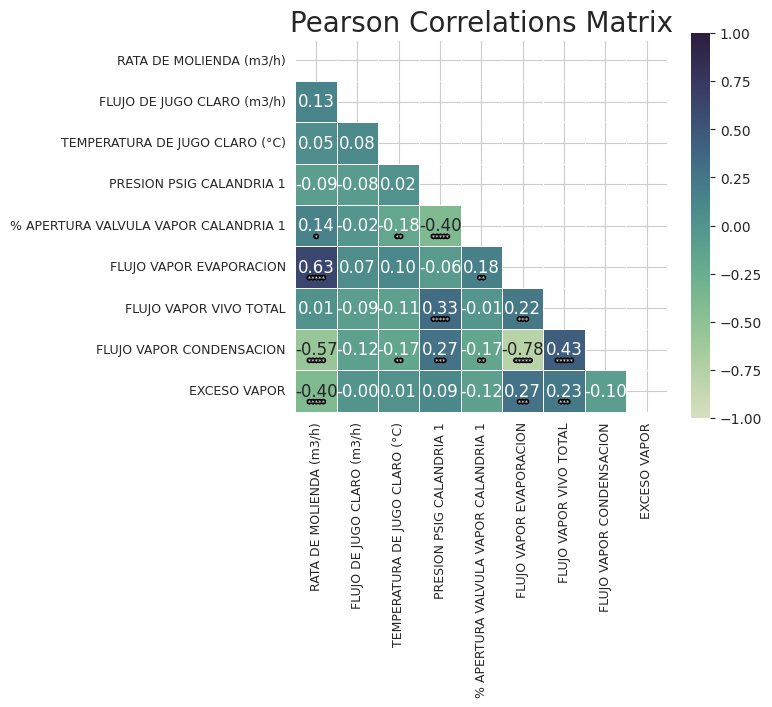

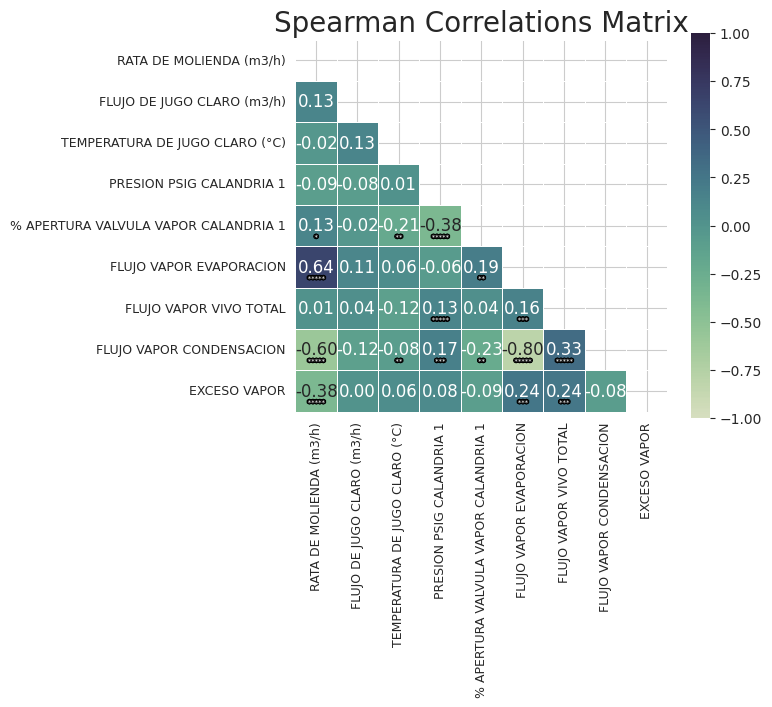

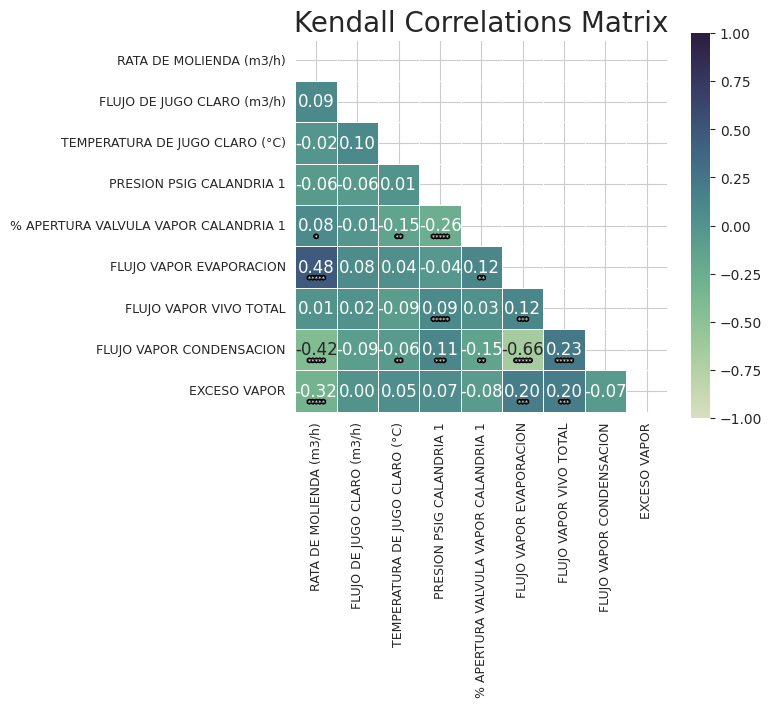

In [200]:
correlation_methods = ['pearson','spearman','kendall']
plot_correlations(df1[atributos],correlation_methods)

En esta segunda fase de interpretación de la información, gracias a las graficas podemos concluir que:
* El % de apertura de valvula de control tiene una relación inversamente proporcional a la presión en la calandria. Esta hipotesis se oberva bajo los 3 métodos teniendo en cuenta el valor alpha que garantiza que esta relación no es producto del azar a pesar que su magnitud no tan significantemente alta.
* Se confirma que las variables de flujo de vapor a evaporacion y condensacion tienen una fuerte relación con la rata de molienda.

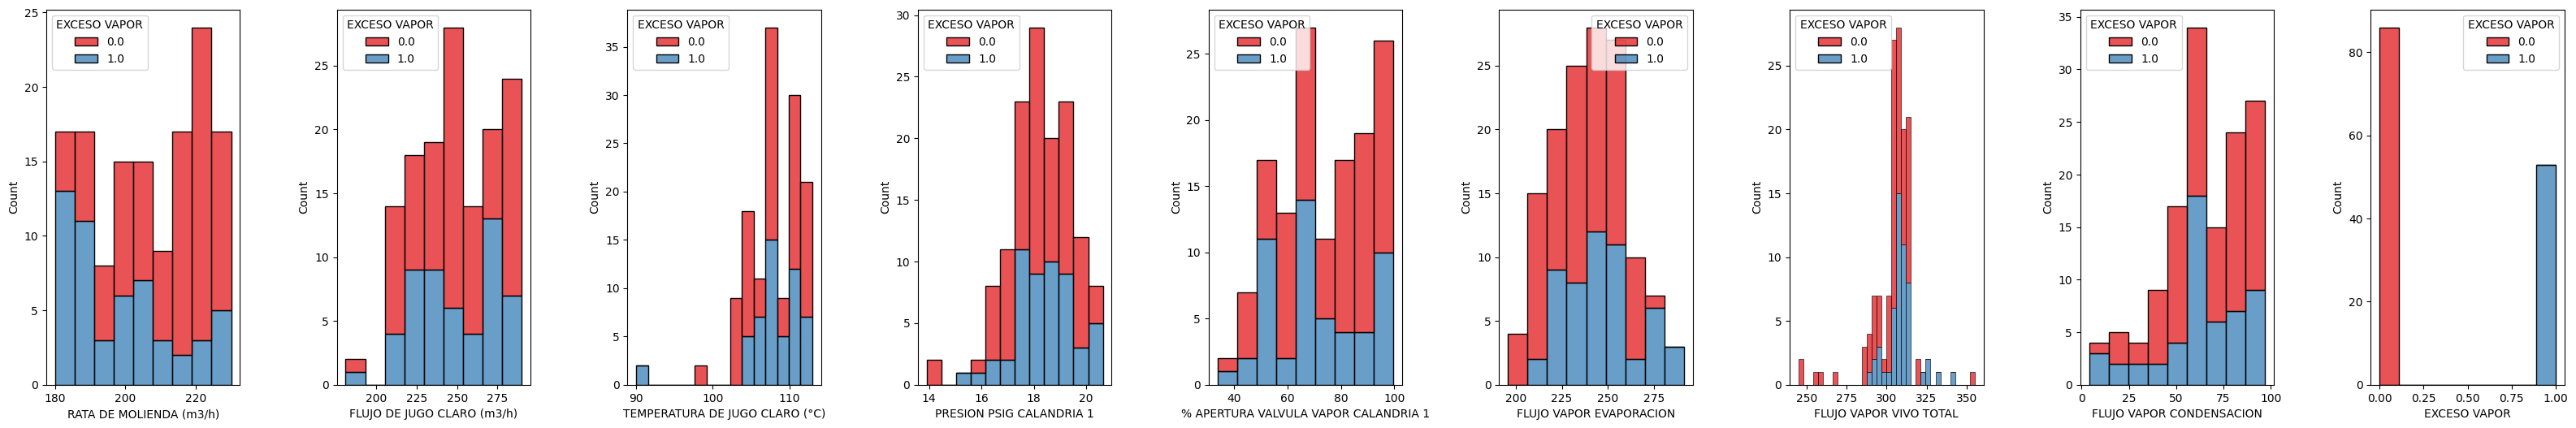

In [201]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(40, 6), squeeze=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, feature in enumerate(atributos):
    row = i // 31  # Calcular el índice de la fila
    col = i % 31   # Calcular el índice de la columna
    sns.histplot(x=df1[feature], hue=df1['EXCESO VAPOR'], multiple="stack", palette="Set1", ax=axes[row, col])
    #axes[row, col].set_title(feature)  # Añadir títulos a las subtramas
    plt.savefig("complete_histogram.png")

plt.show()

En este punto cabe hacer la aclaración nuevamente de que la variable 'EXCESO VAPOR' esta en dos estados asi: 0 == NO y 1 == SI.
* Se puede evidenciar que existe un desbalance en el DATA SET para la variable objetivo, donde el valor "0 == NO" tiene mayor presencia en los registros.
* La condición de EXCESO VAPOR se puede notar con mayor presencia en ratas de molienda bajas.

Text(0, 0.5, 'Atributo')

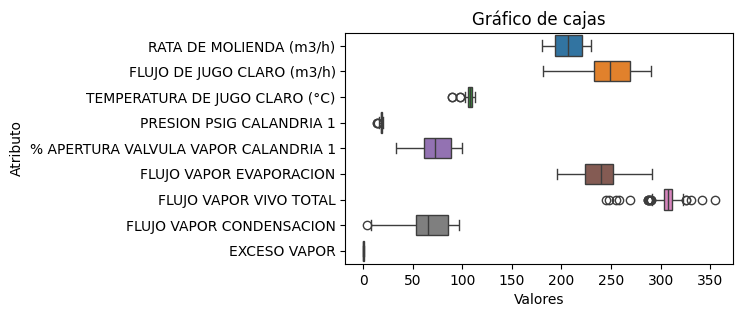

In [202]:
fig, ax = plt.subplots(figsize=(5,3))

# Crea un boxplot con los atributos del eje X verticales
sns.boxplot(data=df1, orient="h", ax=ax)

plt.title('Gráfico de cajas')
plt.xlabel('Valores')
plt.ylabel('Atributo')

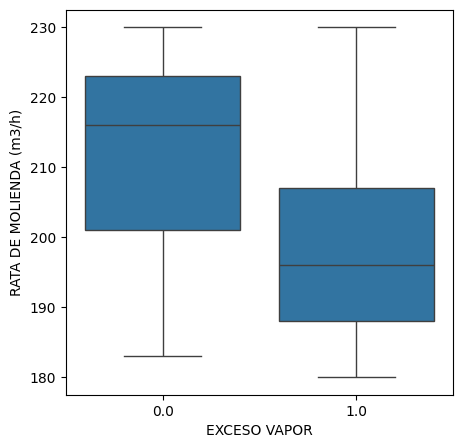

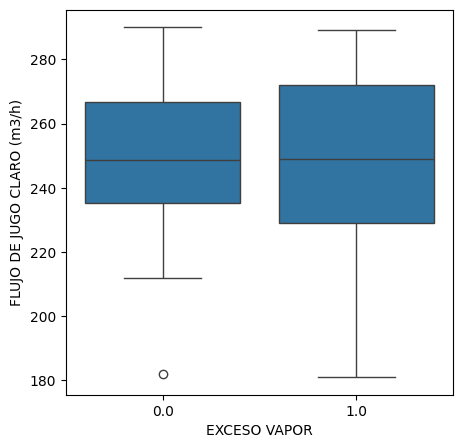

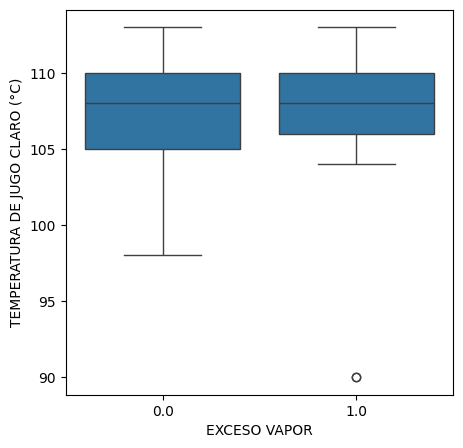

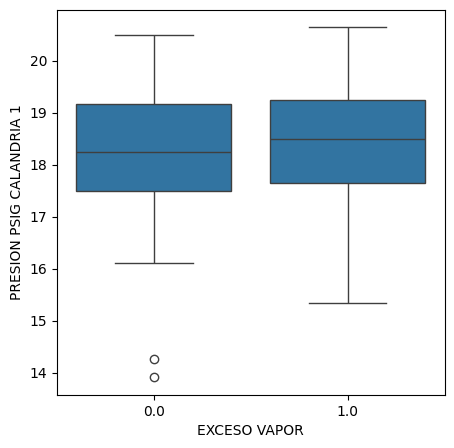

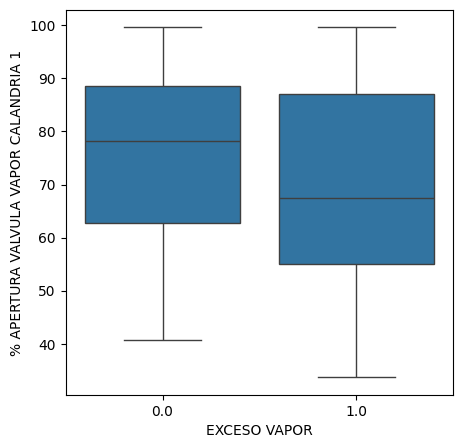

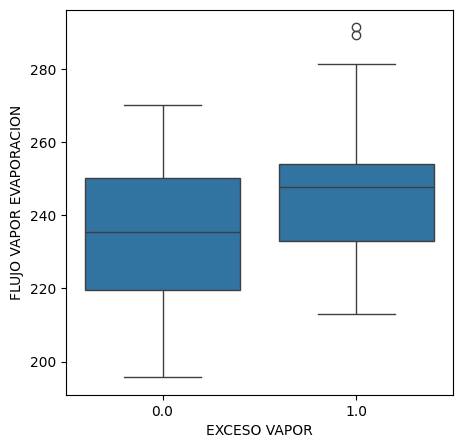

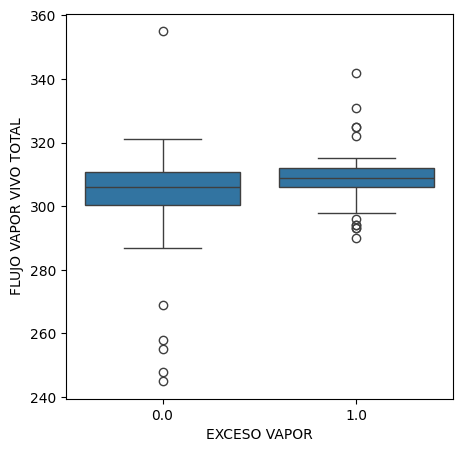

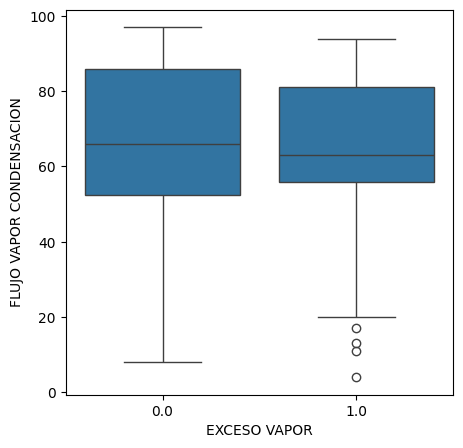

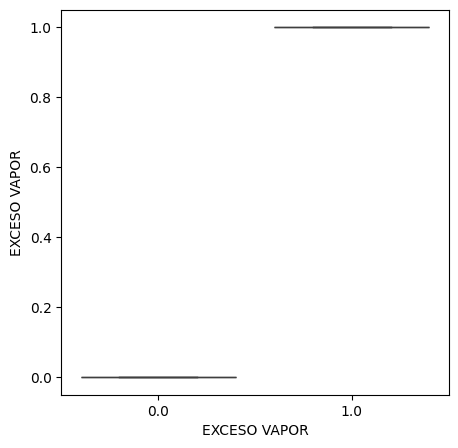

In [205]:
def bivariate_analysis_numerical(df1, var_target, var_numerical):
    for col in var_numerical:
        plt.figure(figsize=(5, 5))
        sns.boxplot(x=var_target,y=col,data=df1)
        plt.show()

bivariate_analysis_numerical(df1,'EXCESO VAPOR',atributos)

Del analisis Bi Variado con cajas podriamos concluir que hay una mayor distribución de casos de EXCESO VAPOR cuanto mas alta es la apertura de la valvula control de vapor.

# Etapa 3: